In [ ]:

%%capture --no-stderr

!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
!pip install -qU langchain-openai
!pip install -qU langchain-community faiss-cpu
!pip install -qU pprint
%pip install -qU langgraph-checkpoint-sqlite
%pip install "unstructured[md]" nltk
%pip install langchain_google_vertexai


In [ ]:
%pip install -qU langgraph-checkpoint-sqlite


In [ ]:
from google.colab import userdata
import os

keys = ['TAVILY_API_KEY',"ANTHROPIC_API_KEY","OPENAI_API_KEY"]
for key in keys:
  if key not in os.environ:
      os.environ[key] = userdata.get(key)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]= userdata.get("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_PROJECT"]="capa-rag"

In [ ]:
import getpass
import os



from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini",temperature = 0)

In [ ]:
import getpass
import os


from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS,InMemoryVectorStore
from langchain.storage import InMemoryStore


from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters.markdown import ExperimentalMarkdownSyntaxTextSplitter
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers import ParentDocumentRetriever

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))
store = InMemoryStore()


vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

#vector_store = InMemoryVectorStore(embedding=embeddings)


#retriever = vector_store.as_retriever()

"""
retriever_from_llm = MultiQueryRetriever.from_llm(
        retriever = retriever, llm = llm)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, chunk_overlap=40, add_start_index=True
)
parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=10000, chunk_overlap=2000, add_start_index=True
"""



'\nretriever_from_llm = MultiQueryRetriever.from_llm(\n        retriever = retriever, llm = llm)\ntext_splitter = RecursiveCharacterTextSplitter(\n    chunk_size=200, chunk_overlap=40, add_start_index=True\n)\nparent_splitter = RecursiveCharacterTextSplitter(\n    chunk_size=10000, chunk_overlap=2000, add_start_index=True\n'

In [ ]:
from langchain.storage import InMemoryStore



'''
retriever_from_llm = MultiQueryRetriever.from_llm(
        retriever = retriever, llm = llm)



retriever = ParentDocumentRetriever(
    vectorstore=vector_store,
    docstore=store,
    child_splitter=text_splitter,
    parent_splitter = parent_splitter
)
'''



child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, chunk_overlap=40, add_start_index=True
)


parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000 , chunk_overlap=400, add_start_index=True
)


In [ ]:
retriever = ParentDocumentRetriever(
    vectorstore=vector_store,
    docstore=store,
    child_splitter=child_splitter
)


In [ ]:
from pathlib import Path

def listar_arquivos_md_com_caminho_recursivo(pasta):
    pasta = Path(pasta)
    arquivos_md = [str(f.resolve()) for f in pasta.rglob('G*.md')]
    return arquivos_md

# Substitua pelo caminho da sua pasta
caminho_da_pasta = '/content/drive/MyDrive/GURPS/'
files = listar_arquivos_md_com_caminho_recursivo(caminho_da_pasta)



In [ ]:
files

['/content/drive/MyDrive/GURPS/GURPS 4e - Basic Set - Campaigns.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Martial Arts.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Powers.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - High-Tech.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Magic.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Low-Tech.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Supers.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Basic Set - Characters.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Fantasy.md',
 '/content/drive/MyDrive/GURPS/GURPS 4e - Ultra-Tech.md']

In [ ]:

from langchain_community.document_loaders import UnstructuredMarkdownLoader

import asyncio

async def load_and_add_docs(files):
    docs = []

    async def process_file(markdown_path):
        print(f"file: {markdown_path}")
        loader = UnstructuredMarkdownLoader(markdown_path)
        doc = await loader.aload()
        doc[0].metadata["book"] = markdown_path.split("/")[-1]
        return doc

    # Cria tarefas assíncronas para processar todos os arquivos em paralelo
    tasks = [process_file(markdown_path) for markdown_path in files]
    results = await asyncio.gather(*tasks)
    return results[0]



#files = [ "./GURPS 4e - Martial Arts.md","/content/GURPS 4e - Basic Set - Campaigns.md","/content/GURPS 4e - High-Tech.md","/content/GURPS 4e - Low-Tech.md","/content/GURPS 4e - Magic.md","/content/GURPS 4e - Powers.md"]

docs = await load_and_add_docs(files)
await retriever.aadd_documents(docs)





file: /content/drive/MyDrive/GURPS/GURPS 4e - Basic Set - Campaigns.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Martial Arts.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Powers.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - High-Tech.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Magic.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Low-Tech.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Supers.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Basic Set - Characters.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Fantasy.md
file: /content/drive/MyDrive/GURPS/GURPS 4e - Ultra-Tech.md


In [ ]:
"""
Execute isto ANTES para popular o vector store com seus livros
"""
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Carregar PDFs
print("📚 Carregando documentos...")
docs = []
pdf_files = files

for pdf in pdf_files:
    try:
        loader = PyPDFLoader(pdf)
        docs.extend(loader.load())
    except FileNotFoundError:
        print(f"⚠️ {pdf} não encontrado")

# 2. Dividir em chunks
print("✂️ Dividindo em chunks...")
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", " ", ""]
)
chunks = splitter.split_documents(docs)

# 3. Criar vector store
print("🔍 Criando vector store...")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    collection_name="books",
    persist_directory="./chroma_db"
)

print(f"✅ {len(chunks)} chunks indexados!")
print(f"   Vector store salvo em: ./chroma_db")

ModuleNotFoundError: No module named 'langchain_chroma'

In [ ]:
from typing_extensions import List, TypedDict,Optional
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from langchain_core.documents import Document
from langgraph.graph.message import MessagesState



class Citation(TypedDict):

    quote: Annotated[str,
        ...,
        "The VERBATIM quote from the specified source that justifies the answer. Always in the same language as the original quote. Do not create anything. Put the verbatim text from the quote."]

    source: Annotated[
        str,...,
        "Sources (book) where the quote was taken. The name of the book should be cited VERBATIM from the source field.",

    ]




class AnswerWithSources(TypedDict):
    """An answer to the question, with source and quotations from the sources used."""

    answer: str
    sources: Annotated[
        List[str],...,
        "List of sources (book) used to answer the question",
    ]

    citations: Annotated[List[Citation],
        ..., "Citations from the given sources that justify the answer. Must be in the same language as the context!!!"]

    see_also: Annotated[List[str],...,'List of terms the user may want to look to expand his search. You may also find interesting terms that surrounds things that may indicate a page (p. or pp.)'
    'So if you see "see Throws from Locks (pp. 118-119).", you want to add as whell "Throws from Locks" as a term.'
    'Or, if you see " break free (p. B371)", add "break free" as a see also.'
    ]

class Question(BaseModel):
    """All the information regarding the question, answer, and the context"""
    question: str
    context: Optional[List[Document]] = Field(default = [],description = "List of contexts for the specific question" )

'''
class QuestionContextAnswer(Question):

    answer: Optional[AnswerWithSources]= Field(description="Answers about the question")
    context: Optional[List[Document]] = Field(description = "List of contexts for the specific question" )
'''



# Define prompt for question-answering

class Questions(BaseModel):
  questions: List[Question] = Field(description="list of questions")



In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph,END
from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

from pprint import pp
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage



#prompt = hub.pull("rlm/rag-prompt")




#structured_questions_llm = llm.with_structured_output(Questions)


# Define state for application
class State(MessagesState):
    main_question: str
    questions : Annotated[Questions,None,"New questions expanding the original question"]
    answer: Annotated[AnswerWithSources,None,"Final Answer, with Quoted Citatation (same language as the book) and book of origin"]




# Define application steps
import asyncio

async def retrieve(state: State):



    async def process_question(question):
        retrieved_docs = await retriever.ainvoke(question.question)
        print(retrieved_docs)
        question.context = retrieved_docs



    # Cria uma lista de tarefas para processar todas as perguntas em paralelo
    tasks = [process_question(question) for question in state["questions"].questions]

    # Executa todas as tarefas simultaneamente
    await asyncio.gather(*tasks)

    questions = state["questions"]
    return Command(update={
        "questions": questions
    })



async def generate(state: State):

    docs_content = ""
    for question in state["questions"].questions:

      docs_content = docs_content + "\n\n".join(doc.page_content + "\n"+ f"Source: {doc.metadata['book']}" for doc in question.context)   + "\n\n"


    prompt = hub.pull("cgomes/rag")


    messages = await prompt.ainvoke({"question": state["main_question"], "context": docs_content})
    structured_llm = llm.with_structured_output(AnswerWithSources)
    response = await structured_llm.ainvoke(messages)


    return {"answer": response,"messages" : [AIMessage(content=json.dumps(response))]}




async def multi_question(state : State):



    multi_question_prompt = hub.pull("gurps_multi_question")
    multi_question = multi_question_prompt | llm.with_structured_output(Questions)

    state["main_question"] = state["messages"][-1].content
    print(state["main_question"])
    questions = await multi_question.ainvoke(
        {
            "messages" : [("user",f'Expand the following question: {state["messages"]}')]
        }

    )
    questions.questions.append(Question(question = state["main_question"]))
    return Command(update= {
        "questions" : questions,"main_question" : state["main_question"]
    })


# Compile application and test
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve",retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("multi_question",multi_question)
graph_builder.add_edge(START, "multi_question")
graph_builder.add_edge("multi_question","retrieve")
graph_builder.add_edge("retrieve","generate")
graph_builder.add_edge("generate",END)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer = memory)



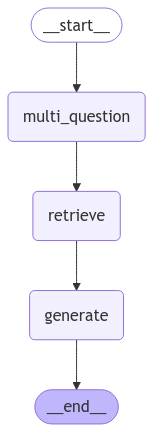

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph(xray=2).draw_mermaid_png()))


In [ ]:
from pprint import pp
import json

async def run_graph(text,subgraphs = False, thread_id ="abc125"):
  config = {"configurable": {"thread_id": thread_id}}


  async for step in graph.astream(
    {"messages" :{"role" : "user", "content" : text} },
    subgraphs=subgraphs,
    config = config):
    print(step)
    print("-- ")


  pp(step)

In [ ]:
await run_graph("If I successfully use Judo Parry to parry two enemies punching me in the same round, can I use an all-out-attack (double) to throw them both using judo throw in the next round?")

In [ ]:
await run_graph("If I have the altered time rate advantage can I use the wait maneuver to wait for a action I myself will perform?")

In [ ]:
import json


await run_graph("No GURPS, como se faz para voar soltando peido?")

{'multi_question': {'questions': Questions(questions=[Question(question='What are the rules for flying in GURPS?', context=[]), Question(question='Are there any specific rules for unconventional methods of flying, such as using flatulence?', context=[]), Question(question='What advantages or disadvantages might be relevant for a character attempting to fly using flatulence?', context=[]), Question(question='How does the GURPS system handle propulsion methods for flight?', context=[]), Question(question='Are there any existing abilities or spells in GURPS that could simulate flight through flatulence?', context=[]), Question(question='What are the physics and mechanics of flight in GURPS?', context=[]), Question(question='How does GURPS handle humorous or unconventional character abilities?', context=[]), Question(question='Are there any cinematic or comedic rules in GURPS that could apply to flying by flatulence?', context=[]), Question(question='What are the potential limitations or d

KeyError: "Input to ChatPromptTemplate is missing variables {'messages'}.  Expected: ['messages'] Received: ['question', 'context']\nNote: if you intended {messages} to be part of the string and not a variable, please escape it with double curly braces like: '{{messages}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [ ]:
import json


await run_graph("O que é um throw from lock? Como é o dano do throw? Qual o total de dano?")


{'multi_question': {'questions': Questions(questions=[Question(question="What is a 'throw from lock' in GURPS?", context=[]), Question(question="How is a 'throw from lock' executed in GURPS?", context=[]), Question(question="What skills or techniques are required to perform a 'throw from lock'?", context=[]), Question(question="Are there any prerequisites or conditions to perform a 'throw from lock'?", context=[]), Question(question="What are the rules for calculating damage from a 'throw from lock'?", context=[]), Question(question="Does the 'throw from lock' have any special modifiers or conditions that affect damage?", context=[]), Question(question="How does the strength of the character performing the 'throw from lock' affect the damage?", context=[]), Question(question="Are there any advantages or disadvantages that modify the damage of a 'throw from lock'?", context=[]), Question(question="What is the total damage calculation for a 'throw from lock'?", context=[]), Question(ques

KeyError: "Input to ChatPromptTemplate is missing variables {'messages'}.  Expected: ['messages'] Received: ['question', 'context']\nNote: if you intended {messages} to be part of the string and not a variable, please escape it with double curly braces like: '{{messages}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [ ]:
class State(MessagesState):
    main_question: str
    questions : Annotated[Questions,None,"New questions expanding the original question"]
    answer: Annotated[AnswerWithSources,None,"Final Answer, with Quoted Citatation (same language as the book) and book of origin"]


In [ ]:
State.__dict__['__annotations__'].keys()

dict_keys(['messages', 'main_question', 'questions', 'answer'])

In [ ]:
    prompt = hub.pull("cgomes/rag")


In [ ]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
When you answer, the citations should be in the same language as the original context.

Let's think step by step.


Question: {question} 
Context: {context} 
Answer:


In [ ]:
config = {"configurable": {"thread_id": "abc123"}}
checkpoint = graph.get_state(config)


In [ ]:
pp(checkpoint.values['messages'])

[HumanMessage(content='Quais opções eu tenho depois de fazer um armlock em outro personagem?', additional_kwargs={}, response_metadata={}, id='a7e12a81-cea2-4155-9024-ad822eaccfa6'),
 AIMessage(content='{"answer": "Ap\\u00f3s aplicar um armlock em outro personagem, voc\\u00ea tem v\\u00e1rias op\\u00e7\\u00f5es. Voc\\u00ea pode tentar danificar o bra\\u00e7o preso, infligindo dano de esmagamento igual \\u00e0 sua margem de vit\\u00f3ria em um teste de resist\\u00eancia r\\u00e1pida contra a for\\u00e7a ou sa\\u00fade do oponente. Al\\u00e9m disso, voc\\u00ea pode tentar lan\\u00e7ar o oponente usando o bra\\u00e7o preso como eixo, o que inflige dano de esmagamento de balan\\u00e7o, ou manter o armlock para causar dor e distra\\u00e7\\u00e3o, dificultando as tentativas do oponente de se libertar.", "sources": ["GURPS 4e - Martial Arts.md"], "citations": [{"quote": "On your next turn \\u2013 and each turn thereafter, until your foe breaks free \\u2013 you may try to damage the trapped ar